In [1]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.syn_data
import matplotlib.pyplot as plt

Create a two node network with just one connection : node 1 -> node 2

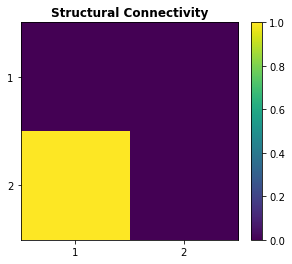

In [2]:
np.random.seed(0)
nn = 2
SC = np.zeros([nn,nn])
SC[1,0] = 1.0

im = plt.imshow(SC)
plt.xticks(np.arange(0,nn),map(str,np.arange(1,nn+1)))
plt.yticks(np.arange(0,nn),map(str,np.arange(1,nn+1)))
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title("Structural Connectivity",fontweight="bold")

np.savez('results/exp2/network.npz', SC=SC)

Node 1 is epileptogenic (x0 = -1.8). Keeps seizing indefinitely.

Node 2 is not epileptogenic (x0 = -2.2 ), however with strong enough coupling (K) seizure should propagate to Node 2.

If the coupling (K) is +ve then the equation for $\dot z_i$ should be:
$$\dot z_i = \frac{1}{\tau_0}(4(x-x_0) - z - K \sum_{j=1}^{N} SC_{ij} (x_j - x_i))$$

Code computing coupling term:

```
matrix vector_differencing(row_vector x) {  
    matrix[num_elements(x), num_elements(x)] D;
    for (i in 1:num_elements(x)) {
      D[i] = x - x[i];
    }
    return D';
  }

  row_vector z_step(row_vector x, row_vector z, row_vector x0, matrix FC, vector Ic,  
                    real time_scale, row_vector z_eta, real sigma, real tau0) {  
    int nn = num_elements(z);  
    row_vector[nn] z_next;
    matrix[nn, nn] D = vector_differencing(x);
    row_vector[nn] gx = to_row_vector(rows_dot_product(FC, D) - Ic .* to_vector(1.8 + x));
    row_vector[nn] dz = inv(tau0) * (4 * (x - x0) - z - gx);
    z_next = z + (time_scale * dz) + z_eta * sigma;
    return z_next;
  }
 ```

The function *matrix_vector_differencing* returns a matrix that has elements:  
$D = \left[ \begin{array}{ccccc}
x_1 - x_1 & ... & x_1 - x_j & ... & x_1 - x_n \\
\vdots \\
x_i - x_1 & ... & x_i - x_j & ... & x_i - x_n \\
\vdots \\
x_n - x_1 & ... & x_n - x_j  & ... & x_n - x_n \\
\end{array}\right]$

Hence the coupling  term in (line 14 above) would be:
$ gx = \left[ \begin{array}{c}
\sum_{j=1}^{N} FC_{1j} (x_1 - x_j) \\
\vdots \\
\sum_{j=1}^{N} FC_{ij} (x_i - x_j) \\
\vdots \\
\sum_{j=1}^{N} FC_{ij} (x_n - x_j) \\
\end{array}\right]  - <Ic,1.8+x>, \text{where } FC = k*SC$

Thus in line 15 the equation for $\dot z$ reads:
$$\dot z_i = \frac{1}{\tau_0}(4(x-x_0) - z - K \sum_{j=1}^{N} SC_{ij} (x_i - x_j))$$
As the difference term is flipped, +ve values of K have inverse effect i.e. when node 1 is seizing node 2 is even more inhibited.

Simulation with +ve and -ve values of K using __vep-fe-rev-08a-fs-sim.stan__

In [3]:
nn = 2
nt = 500
ns = 2
I1 = 3.1
tau0 = 3.0
gain = np.ones([ns,nn])
sigma = 0.0001
k = 2.0
Ic = np.zeros(nn)

x0 = -2.5*np.ones(nn)
x0[0] = -1.8
x0[1] = -2.2
epsilon_star  = 0.0
amplitude = 1.0
offset = 0.0
time_scale_star = 0.0

x_init = -0.5*np.ones(nn)
z_init = 1.5*np.ones(nn)
z_eta = np.random.normal(0.0, 1.0, [nt-1, nn])

data = {'nn':nn, 'nt':nt, 'ns':ns, 'I1':I1, 'tau0':tau0, 
        'gain':gain, 'SC':SC, 'sigma':sigma, 'k':k,
        'x0':x0, 'epsilon_star':epsilon_star,'amplitude':amplitude,
        'offset':offset, 'time_scale_star':time_scale_star,
        'x_init':x_init, 'z_init':z_init, 'z_eta': z_eta,'Ic':Ic}

lib.io.stan.rdump('results/exp2/sim_data.R',data)

stan_fname = './vep-fe-rev-08a-fs-sim'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],
                           block=True,stdout=open('/dev/null','ab'))
sim_cmd = f'{stan_fname} sample algorithm=fixed_param num_samples=1 num_warmup=0 data \
file=results/exp2/sim_data.R output file=results/exp2/sim_out_kpos.csv'
lib.io.stan.create_process(sim_cmd.split(),block=True,stdout=open('/dev/null','ab'))

data['k'] = -2.0
lib.io.stan.rdump('results/exp2/sim_data.R',data)

stan_fname = './vep-fe-rev-08a-fs-sim'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],
                           block=True,stdout=open('/dev/null','ab'))
sim_cmd = f'{stan_fname} sample algorithm=fixed_param num_samples=1 num_warmup=0 data \
file=results/exp2/sim_data.R output file=results/exp2/sim_out_kneg.csv'
lib.io.stan.create_process(sim_cmd.split(),block=True,stdout=open('/dev/null','ab'))


0

source signals for +ve and -ve values of K

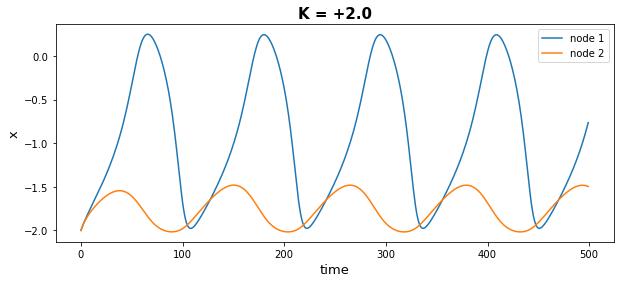

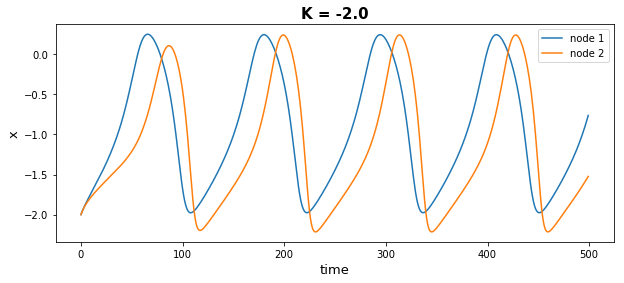

In [6]:
t = lib.io.stan.parse_csv('results/exp2/sim_out_kpos.csv')
x = t['x'][0]
z = t['z'][0]

plt.figure(figsize=[10,4])
plt.plot(x.T)
plt.ylabel('x',fontsize=13.0)
plt.xlabel('time',fontsize=13.0)
plt.legend(['node 1', 'node 2'],loc='upper right')
plt.title('K = +2.0',fontweight='bold',fontsize=15.0)

t = lib.io.stan.parse_csv('results/exp2/sim_out_kneg.csv')
x = t['x'][0]
z = t['z'][0]

plt.figure(figsize=[10,4])
plt.plot(x.T)
plt.ylabel('x',fontsize=13.0)
plt.xlabel('time',fontsize=13.0)
plt.legend(['node 1', 'node 2'],loc='upper right')
plt.title('K = -2.0',fontweight='bold',fontsize=15.0)
